# COVID by county

Similar idea: https://sgallup.shinyapps.io/covidshiny/
Data from: https://github.com/nytimes/covid-19-data

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

Next iteration:
- get county size and get per capita

# Import data from NYTimes



In [49]:
os.chdir(
    "/Users/lacar/Documents/Data_science/Jupyter_notebooks/covid_2020/covid-19-data/"
)

<IPython.core.display.Javascript object>

In [50]:
!git pull

remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 10 (delta 6), reused 10 (delta 6), pack-reused 0
Unpacking objects: 100% (10/10), done.
From https://github.com/nytimes/covid-19-data
   baeca64..fab65f0  master     -> origin/master
Updating baeca64..fab65f0
Fast-forward
 README.md       |    6 +-
 us-counties.csv | 2278 ++++++++++++++++++++++++++++++++++++++++++++++++++++++-
 us-states.csv   |   57 +-
 3 files changed, 2315 insertions(+), 26 deletions(-)


<IPython.core.display.Javascript object>

In [51]:
os.chdir("/Users/lacar/Documents/Data_science/Jupyter_notebooks/covid_2020/")

<IPython.core.display.Javascript object>

In [52]:
df_covid = pd.read_csv("covid-19-data/us-counties.csv")
df_covid["county_state"] = df_covid["county"] + " County, " + df_covid["state"]

<IPython.core.display.Javascript object>

In [53]:
df_covid.head()

,date,county,state,fips,cases,deaths,county_state
0,2020-01-21,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
1,2020-01-22,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
2,2020-01-23,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
3,2020-01-24,Cook,Illinois,17031.0,1,0,"Cook County, Illinois"
4,2020-01-24,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"


<IPython.core.display.Javascript object>

# Reorganize tables

In [54]:
def filter_data(states_list, county_list):
    df_covid_states = df_covid[df_covid["state"].isin(states_list)].copy()
    df_covid_states_county = df_covid_states[
        df_covid_states["county_state"].isin(county_list)
    ].copy()
    df_covid_states_county.sort_values(by=["county_state", "date"], inplace=True)
    df_covid_states_county.reset_index(inplace=True, drop=True)

    # Add new cases, deaths - do manually
    for i in df_covid_states_county.index:
        try:
            county_row = df_covid_states_county.loc[i, "county_state"]
            county_rowahead = df_covid_states_county.loc[i + 1, "county_state"]
            cases_row = df_covid_states_county.loc[i, "cases"]
            cases_rowahead = df_covid_states_county.loc[i + 1, "cases"]
            deaths_row = df_covid_states_county.loc[i, "deaths"]
            deaths_rowahead = df_covid_states_county.loc[i + 1, "deaths"]

            if county_rowahead == county_row:
                df_covid_states_county.loc[i + 1, "new_cases"] = (
                    cases_rowahead - cases_row
                )
                df_covid_states_county.loc[i + 1, "new_deaths"] = (
                    deaths_rowahead - deaths_row
                )
        except:
            continue

    return df_covid_states_county

<IPython.core.display.Javascript object>

In [55]:
def reorg_table_by_category(df_county_state_lim, category):
    # Re-org table
    df_covid_states_county_by_date_county_category = (
        df_county_state_lim.groupby(["date", "county_state"]).sum()[category].unstack()
    )
    df_covid_states_county_by_date_county_category.dropna(how="all", inplace=True)
    df_covid_states_county_by_date_county_category.reset_index(inplace=True)
    return df_covid_states_county_by_date_county_category

<IPython.core.display.Javascript object>

# Visualize

In [56]:
def plot_by_category(
    df_county_state_lim, df_category, category, title, starting_ind, ax
):

    for county in df_county_state_lim["county_state"].unique().tolist():
        ax.plot(df_category["date"], df_category[county], label=county)

    labels = df_category["date"]
    ax.set_xticklabels(labels, rotation=90, fontsize=16)
    ax.set_xlim(starting_ind, len(df_category))
    ax.legend(fontsize=12)
    ax.set_ylabel(category, fontsize=18)
    ax.set_title(title, fontsize=18)
    # plt.tight_layout()

    return county, df_category["date"], df_category[county]

<IPython.core.display.Javascript object>

In [57]:
def plot_all_categories_for_county(states_list, county_list, starting_date):    
    # Get filtered data
    filt_data = filter_data(states, counties)
        
    # Re-org table
    df_covid_sc_bydate_county_cases = reorg_table_by_category(
        filt_data, "cases"
    )
    df_covid_sc_bydate_county_newcases = reorg_table_by_category(
        filt_data, "new_cases"
    )
    df_covid_sc_bydate_county_deaths = reorg_table_by_category(
        filt_data, "deaths"
    )
    df_covid_sc_bydate_county_newdeaths = reorg_table_by_category(
        filt_data, "new_deaths"
    )

    df_category_list = [df_covid_sc_bydate_county_cases, df_covid_sc_bydate_county_newcases, df_covid_sc_bydate_county_deaths, df_covid_sc_bydate_county_newdeaths]
    category_list = ['cases', 'new_cases', 'deaths', 'new_deaths']
    category_title_list = ['cases (cumulative)', 'new_cases', 'deaths (cumulative)', 'new_deaths']
    
    index_starting_date = df_covid_sc_bydate_county_cases[df_covid_sc_bydate_county_cases["date"] == starting_date].index.tolist()[0]
    
    fig, ax = plt.subplots(4, 1, figsize=(12, 16))
      
    for i, category_df in enumerate(df_category_list):
        plot_by_category(
            filt_data,
            category_df,
            category_list[i],
            category_title_list[i],
            index_starting_date,
            ax[i],
        )
    plt.tight_layout()


<IPython.core.display.Javascript object>

# Inputs with different locations

## Local

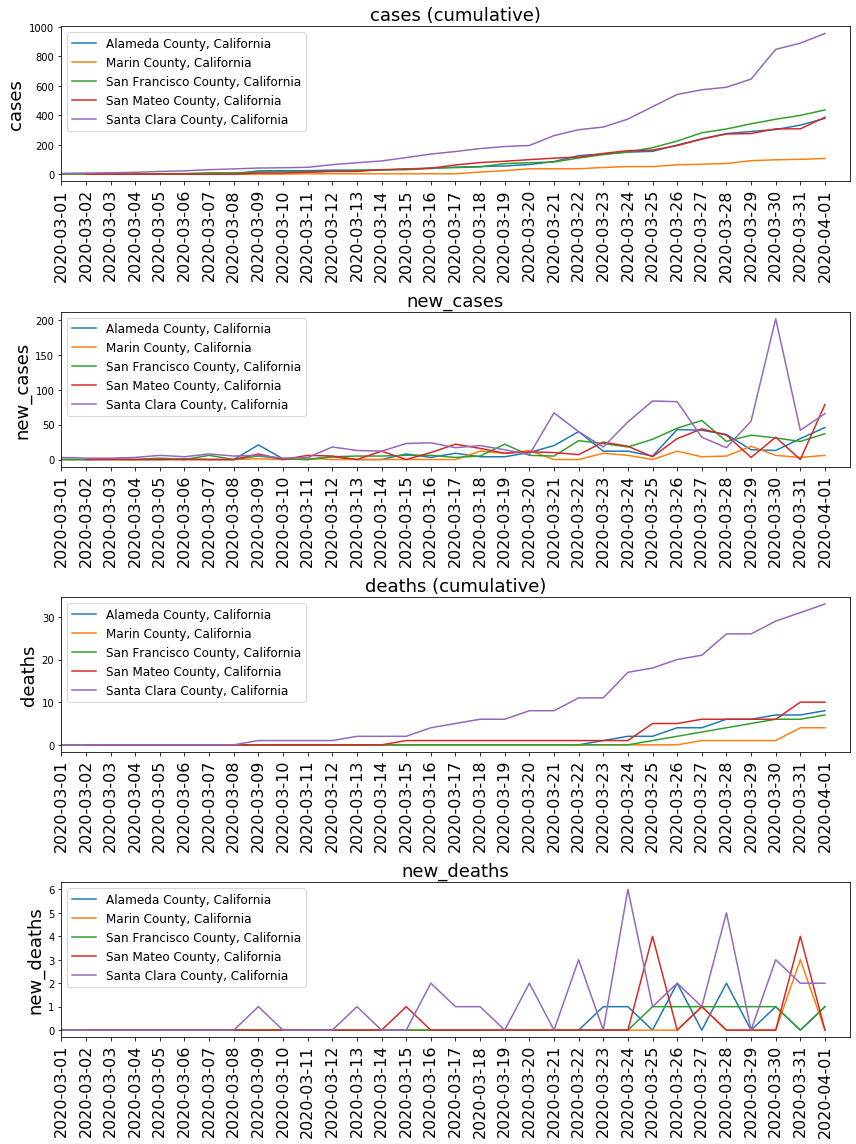

<IPython.core.display.Javascript object>

In [58]:
states = ["California"]
counties = [
    "San Francisco County, California",
    "San Mateo County, California",
    "Santa Clara County, California",
    "Alameda County, California",
    "Marin County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## Some CA counties

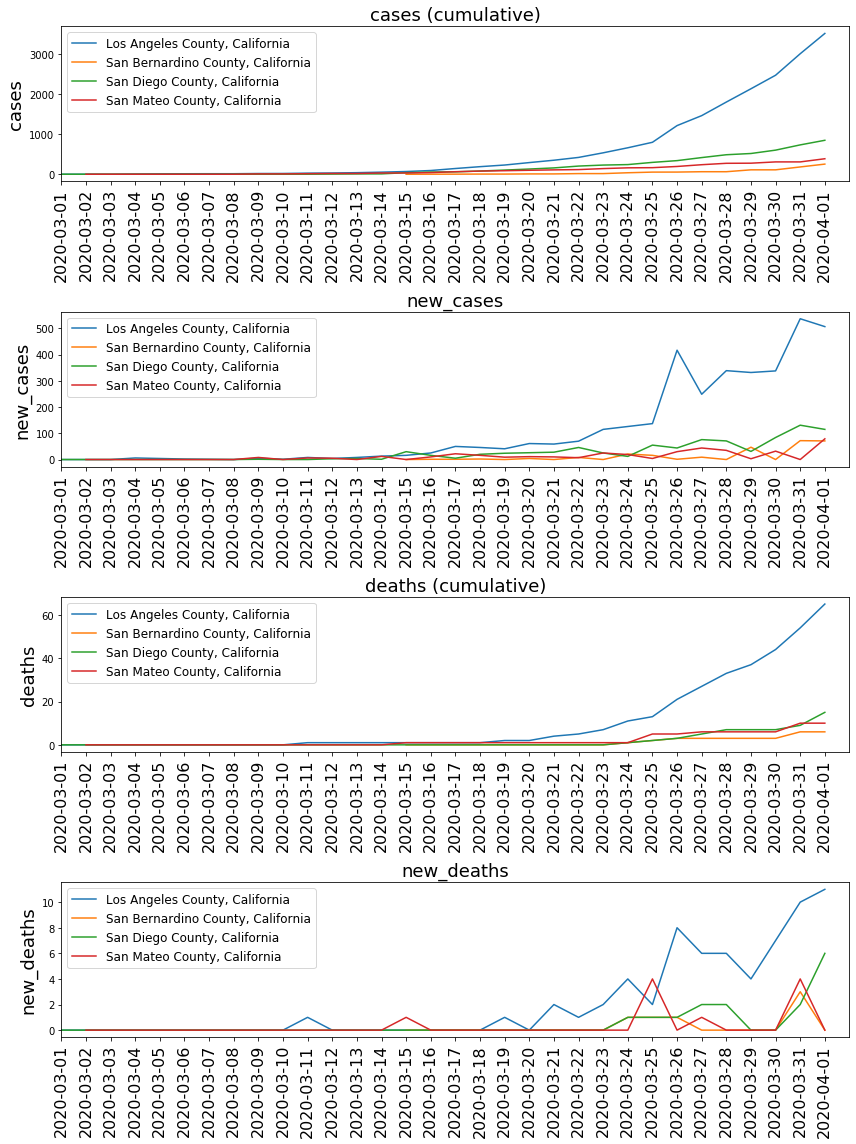

<IPython.core.display.Javascript object>

In [59]:
states = ["California"]
counties = [
    "San Bernardino County, California",
    "San Diego County, California",
    "San Mateo County, California",
    "Los Angeles County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## CA and some East Coast

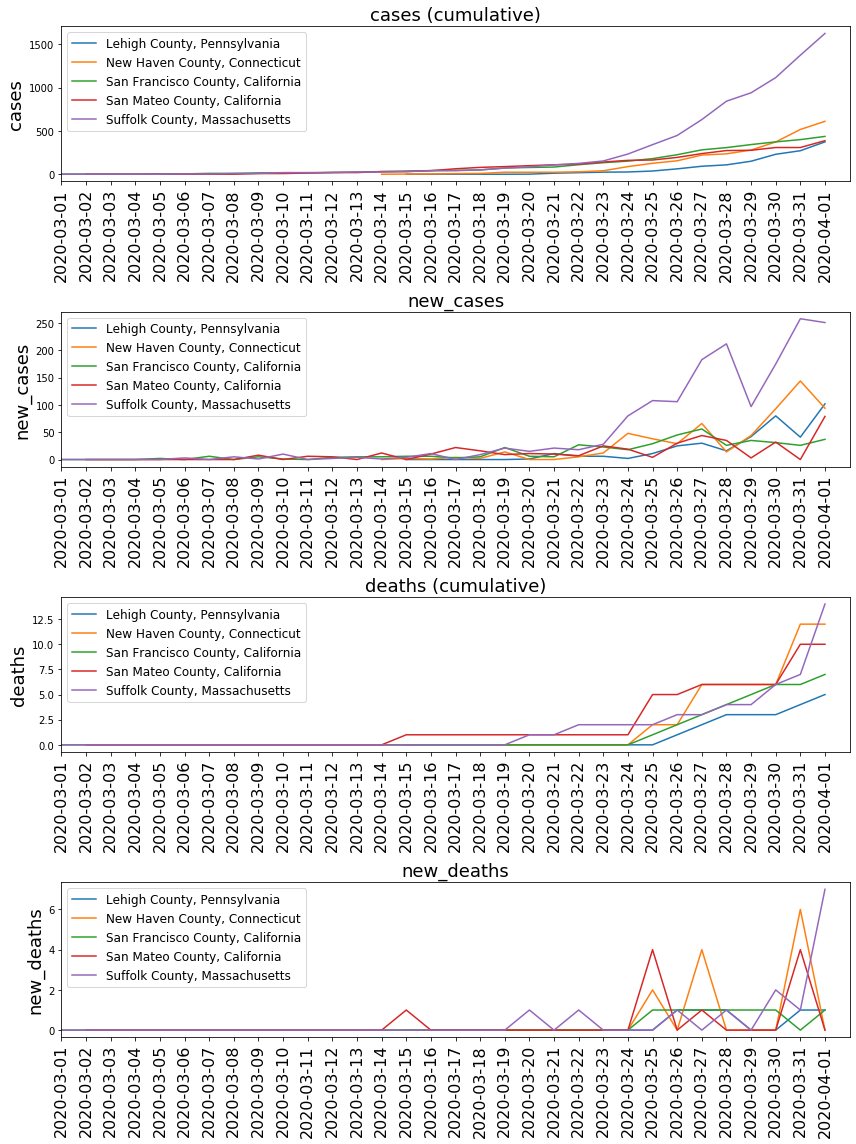

<IPython.core.display.Javascript object>

In [60]:
states = ["Pennsylvania", "Connecticut", "California", "Massachusetts"]
counties = [
    "Suffolk County, Massachusetts",
    "New Haven County, Connecticut",
    "Lehigh County, Pennsylvania",
    "San Francisco County, California",
    "San Mateo County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## New York only

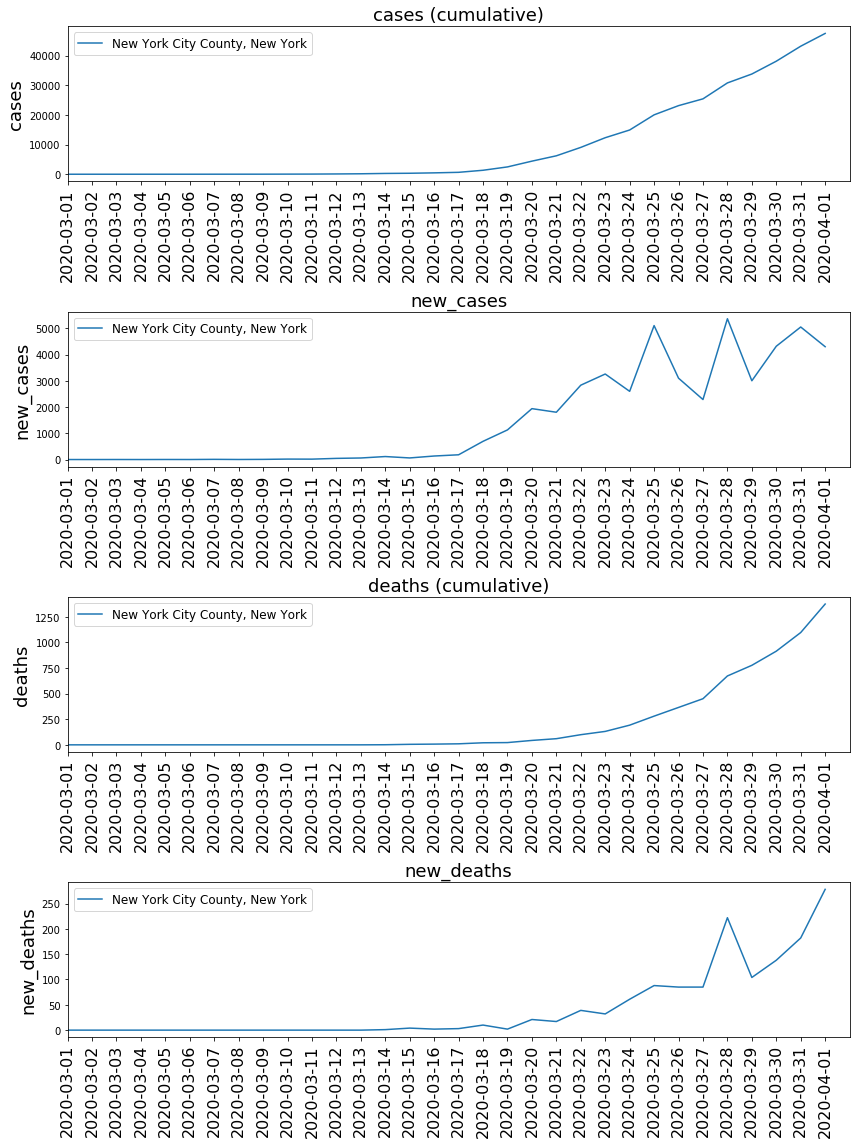

<IPython.core.display.Javascript object>

In [61]:
states = ["New York"]
counties = [
    "New York City County, New York",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## CA, CO, PA, Southeast

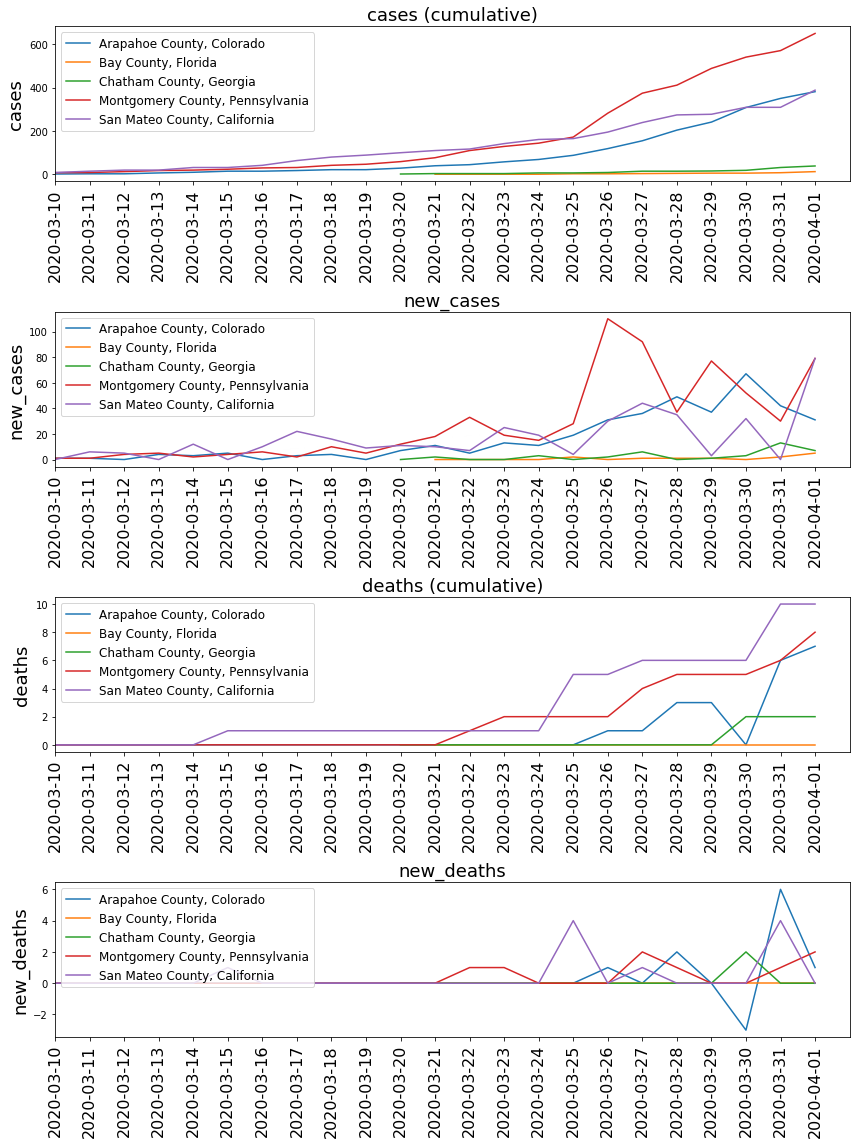

<IPython.core.display.Javascript object>

In [62]:
states = ["Colorado", "California", "Pennsylvania", "Georgia", "Florida"]
counties = [
    "Arapahoe County, Colorado",
    "Chatham County, Georgia",
    "Montgomery County, Pennsylvania",
    "Leon Countydd, Florida",
    "Bay County, Florida",
    "San Mateo County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-10")

## CA, WA, Las Vegas

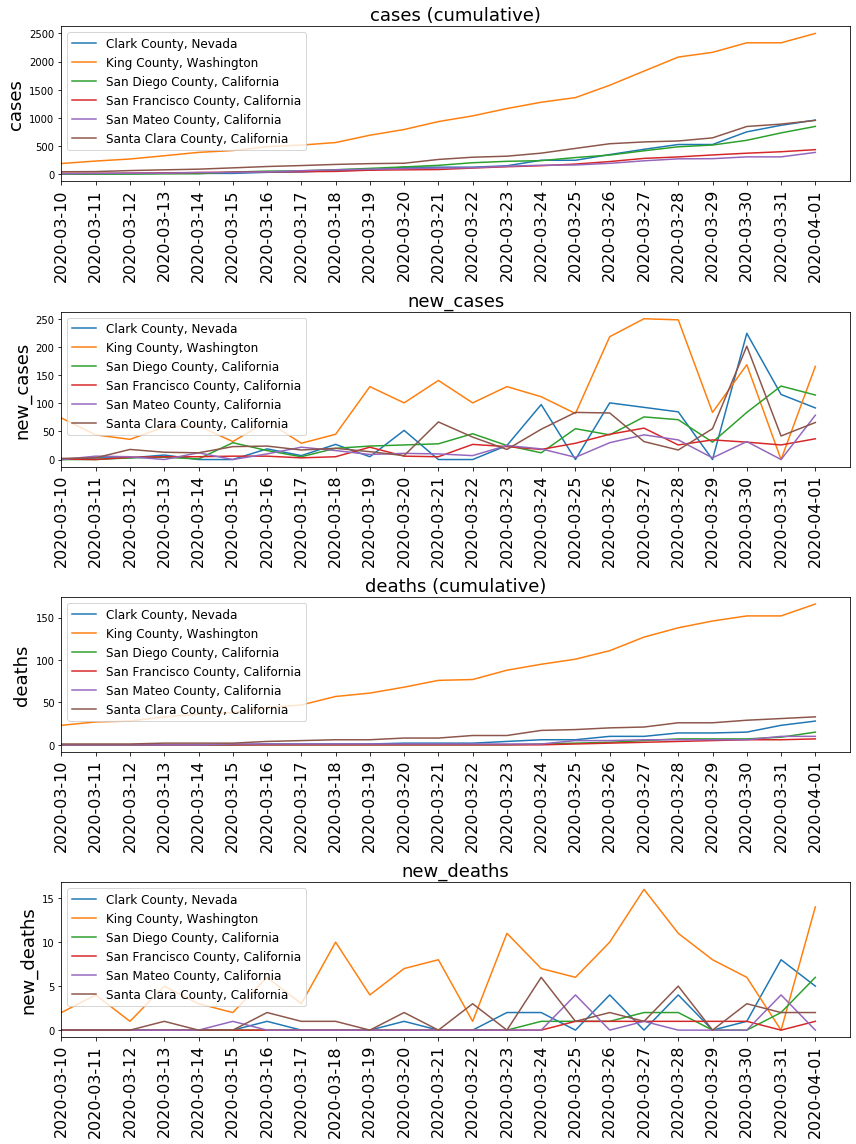

<IPython.core.display.Javascript object>

In [63]:
states = ["Nevada", "California", "Washington"]
counties = [
    "Clark County, Nevada",
    "King County, Washington",
    "San Francisco County, California",
    "San Mateo County, California",
    "Santa Clara County, California",
    "San Diego County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-10")